In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

**1. transforms.ToTensor()**

MNIST images are originally in PIL Image format (28×28 grayscale).

This converts them into a PyTorch Tensor, and also scales pixel values to the [0,1] range.

Originally, pixel values are between 0–255.

After ToTensor(), each pixel becomes pixel / 255.


**2. transforms.Normalize((0.5,), (0.5,))**

This further shifts and scales pixel values to the [-1, 1] range,

Let say, x is the pixel value in [0,1] (after ToTensor()), then after applying the transforms.Nowmalize(), it will below:

0 → -1

0.5 → 0

1 → +1

We normalize like this because, Neural networks train better when inputs are centered around zero (mean ≈ 0).

It helps speed up training and prevents issues like exploding/vanishing gradients.

In [12]:
# ----- Dataset (MNIST) -----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000)

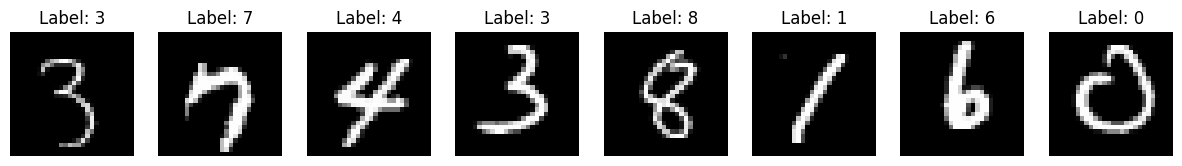

In [14]:
## Visualize the data

import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')  # grayscale
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.show()

In [15]:
## Teacher Model

import torch
import torch.nn as nn

# ----- Teacher Model (2 hidden layers) -----
class TeacherMLP(nn.Module):
    def __init__(self, hidden1=512, hidden2=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 10)  # 10 output classes (digits)
        )
    def forward(self, x):
        return self.net(x)

In [16]:
# Create instances
teacher = TeacherMLP(hidden1=512, hidden2=256)

print(teacher)

TeacherMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [18]:
# ----- Train Teacher -----
def train_teacher(model, loader, epochs=1, lr=1e-3):

    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()

    for ep in range(epochs):
        total_loss = 0
        for x, y in loader:
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Teacher Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")

In [19]:
train_teacher(teacher, train_loader)

Teacher Epoch 1: Loss = 0.2997


In [21]:
## View updated weights
print(teacher.state_dict())

OrderedDict({'net.1.weight': tensor([[ 0.0093, -0.0179,  0.0144,  ...,  0.0072,  0.0042,  0.0481],
        [ 0.0237,  0.0079, -0.0020,  ..., -0.0216,  0.0173, -0.0258],
        [ 0.0347,  0.0281, -0.0131,  ..., -0.0241, -0.0019,  0.0201],
        ...,
        [-0.0260, -0.0103,  0.0104,  ..., -0.0424,  0.0168,  0.0087],
        [-0.0016, -0.0251,  0.0227,  ..., -0.0077,  0.0161, -0.0075],
        [ 0.0104,  0.0029,  0.0318,  ...,  0.0024,  0.0120,  0.0012]]), 'net.1.bias': tensor([ 0.0056, -0.0409, -0.0156, -0.0043, -0.0194,  0.0025,  0.0088,  0.0285,
        -0.0241, -0.0022, -0.0027, -0.0004,  0.0380, -0.0369,  0.0376,  0.0070,
         0.0015, -0.0278,  0.0048,  0.0006, -0.0013, -0.0094,  0.0089, -0.0288,
        -0.0040, -0.0160,  0.0278,  0.0068,  0.0055, -0.0263,  0.0297, -0.0427,
         0.0005, -0.0254, -0.0286, -0.0069, -0.0326, -0.0284, -0.0357, -0.0006,
         0.0150,  0.0089, -0.0281,  0.0230, -0.0370, -0.0138,  0.0024, -0.0385,
        -0.0210,  0.0295,  0.0152, -0.0037

In [22]:
# # ----- Freeze Teacher -----
# for param in teacher.parameters():
#     param.requires_grad = False
# teacher.eval()
# print("Teacher model trained and frozen.")

In [23]:
# ----- Student Model (1 hidden layer) -----
class StudentMLP(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 10)  # smaller model, only 1 hidden layer
        )
    def forward(self, x):
        return self.net(x)

In [24]:
student = StudentMLP(hidden=128)
print(student)

StudentMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


## **There are two approaches:**

1. PreTrain the student model with hard labels and then perform the distillation
2. Do the knowledge distillation on student model (just the initialized model with some random weights) from the Teacher model soft labels

In [28]:
## Approach 2

# ----- Distillation Training -----
temperature = 2.0
alpha = 0.7
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(student.parameters(), lr=1e-3)

def distill(student, teacher, loader, epochs=1):
    for ep in range(epochs):

        student.train()

        total_loss = 0

        for x, y in loader:
            # Teacher outputs
            with torch.no_grad():
                t_logits = teacher(x)
                t_probs = torch.softmax(t_logits / temperature, dim=1)

            # Student outputs
            s_logits = student(x)
            s_log_probs = torch.log_softmax(s_logits / temperature, dim=1)

            # Losses
            loss_soft = kl_loss(s_log_probs, t_probs) * (temperature**2)
            loss_hard = ce_loss(s_logits, y)
            loss = alpha * loss_soft + (1 - alpha) * loss_hard

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            total_loss += loss.item()
        print(f"Student Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")

In [29]:
distill(student, teacher, train_loader)

Student Epoch 1: Loss = 0.5786


In [30]:
# ----- Evaluation Function -----
def evaluate(model, loader, name="Model"):
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total * 100
    print(f"{name} Accuracy: {acc:.2f}%")
    return acc

In [34]:
# Evaluate both Teacher and Student

evaluate(teacher, test_loader, "Teacher")

evaluate(student, test_loader, "Student")

Teacher Accuracy: 94.77%
Student Accuracy: 92.96%


92.96

In [35]:
## Approach 1

## Pretrain student on hard labels (optional warm-up)
def pretrain_student(student, loader, epochs=1, lr=1e-3):
    student.train()
    opt = optim.Adam(student.parameters(), lr=lr)
    ce_loss = nn.CrossEntropyLoss()
    for ep in range(epochs):
        for x, y in loader:
            opt.zero_grad()
            out = student(x)
            loss = ce_loss(out, y)
            loss.backward()
            opt.step()


In [39]:
pretrain_student(student, train_loader, epochs=1)

In [40]:
# ----- Distillation Training -----
temperature = 2.0
alpha = 0.7
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(student.parameters(), lr=1e-3)

def distill(student, teacher, loader, epochs=1):
    for ep in range(epochs):

        student.train()

        total_loss = 0

        for x, y in loader:
            # Teacher outputs
            with torch.no_grad():
                t_logits = teacher(x)
                t_probs = torch.softmax(t_logits / temperature, dim=1)

            # Student outputs
            s_logits = student(x)
            s_log_probs = torch.log_softmax(s_logits / temperature, dim=1)

            # Losses
            loss_soft = kl_loss(s_log_probs, t_probs) * (temperature**2)
            loss_hard = ce_loss(s_logits, y)
            loss = alpha * loss_soft + (1 - alpha) * loss_hard

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            total_loss += loss.item()
        print(f"Student Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")

In [41]:
distill(student, teacher, train_loader)

Student Epoch 1: Loss = 0.0795


In [42]:
# Evaluate both Teacher and Student

evaluate(teacher, test_loader, "Teacher")

evaluate(student, test_loader, "Student")

Teacher Accuracy: 94.77%
Student Accuracy: 95.76%


95.76